This notebook is meant to allow the data collection / plotting of any quantum state we can produce in the set up.

In [2]:
'''
Author: Lev Gruber
Last Update: 6/2/2024

This file uses code from Oscar's process_expt_richard.py in Summer 2023 to brute force
calculate eta and chi values (for the state cos(eta)PHI+ + sin(eta)e^i*chi PHI-) in which W is positive
and W' is negative. 

It does so by:
1. Creating theoretical density matrices at a variety of eta values and 1-2 chi values
2. Computing both W and W' witnesses for each density matrix
3. Pushing values with +W and -W' into one df, and values with +W, +W' into another. 

In the future, I hope to add functionality to compute V witnesses for states for which W and W' are positive.
'''

# Imports
import numpy as np
from os.path import join, dirname, abspath
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import sympy as sp

from uncertainties import ufloat
from uncertainties import unumpy as unp

# Original code adapted from Oscar Scholin in Summer 2023
from sample_rho import *
from rho_methods import *

In [50]:
### Helper Functions ###
def ket(data):
    return np.array(data, dtype=complex).reshape(-1,1)


def get_theo_rho(state, eta, chi):
    '''
    Calculates the density matrix (rho) for a given set of paramters (eta, chi) for Stuart's states
    
    Parameters:
    state (string): Which state we want
    eta (float): The parameter eta.
    chi (float): The parameter chi.
    
    Returns:
    numpy.ndarray: The density matrix (rho)
    '''
    # Define kets and bell states in vector form 
    H = ket([1,0])
    V = ket([0,1])
    R = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (-1j)])
    L = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (1j)])
    D = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (1)])
    A = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (-1)])
    
    PHI_PLUS = (np.kron(H,H) + np.kron(V,V))/np.sqrt(2)
    PHI_MINUS = (np.kron(H,H) - np.kron(V,V))/np.sqrt(2)
    PSI_PLUS = (np.kron(H,V) + np.kron(V,H))/np.sqrt(2)
    PSI_MINUS = (np.kron(H,V) - np.kron(V,H))/np.sqrt(2)
    
    ##  The following 2 states inspired the Ws
    
    if state == 'phi plus, phi minus':
        phi = np.cos(eta)*PHI_PLUS + np.exp(1j*chi)*np.sin(eta)*PHI_MINUS
    
    if state == 'psi plus, psi minus':
        phi = np.cos(eta)*PSI_PLUS + np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    ## The following 6 states inspired the W primes
    
    if state == 'phi plus, psi minus':
        phi = np.cos(eta)*PHI_PLUS + np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    if state == 'phi minus, psi plus':
        phi = np.cos(eta)*PHI_MINUS + np.exp(1j*chi)*np.sin(eta)*PSI_PLUS
    
    if state == 'phi plus, i psi plus':
        phi = np.cos(eta)*PHI_PLUS + 1j*np.exp(1j*chi)*np.sin(eta)*PSI_PLUS
    
    if state == 'phi plus, i phi minus':
        phi = np.cos(eta)*PHI_PLUS + 1j*np.exp(1j*chi)*np.sin(eta)*PHI_MINUS

    if state == 'psi plus, i psi minus':
        phi = np.cos(eta)*PSI_PLUS + 1j*np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    if state == 'phi minus, i psi minus':
        phi = np.cos(eta)*PHI_MINUS + 1j*np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    ## The following state(s) are an attempt to find new positive W negative W prime states.
    if state == 'HR_VL':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,R) + (1 - np.exp(1j*chi))/2 * np.kron(V,L)
    
    if state == 'HR_iVL':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,R) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,L)
    
    if state == 'HL_VR':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,L) + (1 - np.exp(1j*chi))/2 * np.kron(V,R)
        
    if state == 'HL_iVR':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,L) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,R)
        
    if state == 'HD_VA':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,D) + (1 - np.exp(1j*chi))/2 * np.kron(V,A)
    
    if state == 'HD_iVA':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,D) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,A)
        
    if state == 'HA_VD':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,A) + (1 - np.exp(1j*chi))/2 * np.kron(V,D)
    
    if state == 'HA_iVD':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,A) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,D)
    
    # create rho and return it
    rho = phi @ phi.conj().T
    return rho
    
def generate_state(state_list, state_prob, eta_chi):
    '''
    Uses above helper functions to generate a given mixed state
    
    Parameters:
    state_list (list): list of state names that are to be mixed, must match creatable state names above
    state_prob (list): probability of each state being mixed in state_list, must match index
    eta_chi (list): what eta and chi to use for each state, must match index
    
    Returns:
    rho: an NxN density matrix
    '''
    
    # get individual rho's per state in state_list, taking probability into account
    individual_rhos = []
    for i, state in enumerate(state_list):
        individual_rhos.append(state_prob[i] * get_theo_rho(state, *eta_chi))
    # sum all matrices in individual rhos
    rho = np.sum(individual_rhos, axis = 0)
    
    return rho
        
    
def create_noise(rho, power):
    '''
    Adds noise of order power to a density matrix rho
    
    Parameters:
    rho: NxN density matrix
    power: integer multiple of 10
    
    Returns:
    noisy_rho: rho with noise
    '''
    
    # get size of matrix
    n, _ = rho.shape
    
    # iterature over matrix and add some random noise to each elemnent
    for i in range(n):
        for j in range(n):
            rando = random.random() / (10 ** power)
            rho[i,j] += rando
    noisy_rho = rho
    
    return noisy_rho

######## Helper methods for analyzing density matrices
def analyze_rho(rho_actual, verbose = False, id='id'):
    '''; 
    __
    inputs:
        filenames: list of filenames to analyze
        settings: dict of settings for the experiment
        id: str, special identifier of experiment; used for naming the df
    __
    returns: df with:
        - W theory (adjusted for purity) and W expt and W unc
        - W' theory (adjusted for purity) and W' expt and W' unc
    '''
    
    # calculate W and W' theory
    W_T_ls, W_params = compute_witnesses(rho = rho_actual, return_all = True, return_params = True) # theory #, return_all = True, return_params = True
    
    # parse lists
    W_min = min(W_T_ls[:6])
    Wp_t1 = min(W_T_ls[6:9])
    Wp_t2 = min(W_T_ls[9:12])
    Wp_t3 = min(W_T_ls[12:15])
    
    if verbose:
        # If verbose, return not just the 4 values but also the names of the minimal witnesses!
        # Define dictionary to get name of
        all_W = ['W1','W2', 'W3', 'W4', 'W5', 'W6', 'Wp1', 'Wp2', 'Wp3', 'Wp4', 'Wp5', 'Wp6', 'Wp7', 'Wp8', 'Wp9']
        index_names = {i: name for i, name in enumerate(all_W)}

        # Get which W/W' were minimized
        W_min_name = index_names.get(W_T_ls.index(W_min), 'Unknown')
        Wp1_min_name = index_names.get(W_T_ls.index(Wp_t1), 'Unknown')
        Wp2_min_name = index_names.get(W_T_ls.index(Wp_t2), 'Unknown')
        Wp3_min_name = index_names.get(W_T_ls.index(Wp_t3), 'Unknown')
        
        # Return the params as well, add in if return_params = True in compute_witness call
        W_param = W_params[0]
        Wp1_param = W_params[1]
        Wp2_param = W_params[2]
        Wp3_param = W_params[3]
        
        # Find names from dictionary and return them and their values
        return W_min, Wp_t1, Wp_t2, Wp_t3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param
    else:
         return W_min, Wp_t1, Wp_t2, Wp_t3

def plot_all(name, etas, chis = [], eta_sweep=False):
    '''
    Plots data from main
    
    Parameters:
    names (list): which csv names to read
    etas (list): list of eta values
    chis (list): list of chi values, only used if eta_sweep=True
    eta_sweep (bool): whether we want to produce a plot of witness val versus eta
    '''
    fig, ax = plt.subplots()
    
    
    # differentiate between a sweep over eta or chi
    if eta_sweep == True:
        chis_nice = []
        for i, chi in enumerate(chis):
            # Read in CSV
            data = pd.read_csv(f'paper_states/{name}_{chis[i]}.csv')
            # Extract data
            W = data['W']
            min_Wp = data['min_W_prime']
            eta = data['eta_arr']
            chis_nice.append(round(np.degrees(chi)))
            # Plot data
            ax.plot(eta, W, label = f'$W, \chi = {chis_nice[i]}$')
            ax.plot(eta, min_Wp, label = f'$W\prime, \chi = {chis_nice[i]}$')
    else:   
        etas_nice = []     
        for i, eta in enumerate(etas):
            
            # Read in CSV
            data = pd.read_csv(f'paper_states/{name}_{etas[i]}.csv')
            # Extract data
            W = data['W']
            min_Wp = data['min_W_prime']
            chi = data['chi']

            # Plot data
            etas_nice.append(round(np.degrees(eta)))
            ax.plot(chi, W, label = f'$W, \eta = {etas_nice[i]}$')
            ax.plot(chi, min_Wp, label = f'$W\prime, \eta = {etas_nice[i]}$')
    if not eta_sweep:
        name = f'{name}_{etas_nice[0]}'  #_{etas_nice[1]}_{etas_nice[2]}_{etas_nice[3]}
    if eta_sweep:
        name = f'{name}_{chis_nice}'
    print(name)
    ax.axhline(0, color='black', linewidth=0.5) 
    ax.set_title(f'State {name}', fontsize=12)
    ax.set_ylabel('Witness value', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=6)
    plt.tight_layout()
    ax.legend(fontsize=8, loc = 'upper right')
    ax.set_xlabel('$\chi$', fontsize=12)
    if eta_sweep:
        ax.set_xlabel('$\eta$',)
    plt.savefig(f'paper_states/{name}.pdf')

<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:207: SyntaxWarning: invalid escape sequence '\p'
<>:221: SyntaxWarning: invalid escape sequence '\e'
<>:222: SyntaxWarning: invalid escape sequence '\p'
<>:234: SyntaxWarning: invalid escape sequence '\c'
<>:236: SyntaxWarning: invalid escape sequence '\e'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:207: SyntaxWarning: invalid escape sequence '\p'
<>:221: SyntaxWarning: invalid escape sequence '\e'
<>:222: SyntaxWarning: invalid escape sequence '\p'
<>:234: SyntaxWarning: invalid escape sequence '\c'
<>:236: SyntaxWarning: invalid escape sequence '\e'
C:\Users\levjg\AppData\Local\Temp\ipykernel_69184\1718411317.py:206: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(eta, W, label = f'$W, \chi = {chis_nice[i]}$')
C:\Users\levjg\AppData\Local\Temp\ipykernel_69184\1718411317.py:207: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(eta, min_Wp, label = f'$W\prime, \chi = {chis_nice[i]}$')
C:\Users\levjg\AppData\Lo

### Test a single pure or mixed state

All data was 7.21874863950573e-08 5.6874987522439285e-08 5.7628153870459275e-08 -1.7819177648001396e-07 W1 Wp2 Wp6 Wp9
All data was 0.0022084740621132566 0.0017383681816709236 0.0017383681816750987 -0.006409436735904099 W2 Wp1 Wp6 Wp9
All data was 0.00862938939962048 0.006773327858431027 0.006773327858431764 -0.02358465214481238 W2 Wp1 Wp6 Wp9
All data was 0.018795078449736005 0.014682766701754047 0.014682766701754559 -0.04730231200770867 W2 Wp1 Wp6 Wp9
All data was 0.031900979876532023 0.024756243348272394 0.024756243348272467 -0.07330270035795881 W2 Wp1 Wp6 Wp9
All data was 0.04676732219918458 0.03599125233976706 0.0359912523397671 -0.09825744456596518 W1 Wp2 Wp6 Wp9
All data was 0.061799919931381495 0.04711168742056979 0.04711168742056878 -0.11978237136356294 W2 Wp1 Wp6 Wp9
All data was 0.07500496474507004 0.056648003398674346 0.05664800339867786 -0.13622721106329172 W1 Wp2 Wp6 Wp9
All data was 0.08418914839579658 0.06313396459102201 0.06313396459102187 -0.14650633365024526 W2 Wp2 W

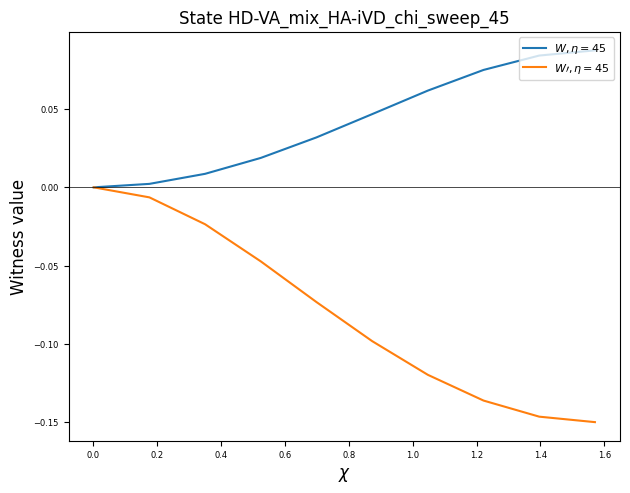

In [54]:
num_chis = 10 # number of chi points to take
num_etas = 1  # the number of etas you choose below
etas = [np.pi/4]# [np.pi/12, np.pi/6, np.pi/4 , np.pi/3]
chis = np.linspace(0.001, np.pi/2, num_chis)
file_name = 'HD-VA_mix_HA-iVD_chi_sweep' # choose descriptively based on names list
names = ['HD_VA', 'HA_iVD']
probs = [0.35, 0.65] # single value list of 1 if creating a pure state
eta_sweep = False # Are you sweeping over eta or chi? False if chi.
plot = True

####### Create states and get rhos

# Instantiate states to sweep over
states_names = [[] for _ in range(num_etas)]
states = [[] for _ in range(num_etas)]
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names[i].append((np.rad2deg(eta), np.rad2deg(chi)))
        states[i].append((eta, chi)) 

# Obtain the density matrix for each state
rho_actuals = [[] for _ in range(num_etas)]
for i, state_set in enumerate(states_names):
    for j, state_n in enumerate(state_set):
        rad_angles = states[i][j]
        rho_actuals[i].append(generate_state(names, probs, rad_angles)) #name, 

# Instantiate lists to save as csv
W_arr = [[] for _ in range(num_etas)]  # lowest W value (4 is number of etas)
Wp_arr = [[] for _ in range(num_etas)]     # lowest W prime value
eta_arr = [[] for _ in range(num_etas)]
chi_arr = [[] for _ in range(num_etas)]

####### Witness each rho and save it

### Save witness values to above lists of lists
for i, rhos_per_eta in enumerate(rho_actuals):
    for j, rho in enumerate(rhos_per_eta):
        # find the minimum witness expectation value of the 3 w primes and of the W.
        # Add in to get which W was minimum: W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param,  verbose = True
        e = etas[i]
        c = chis[j]
        WM, WP1, WP2, WP3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho, verbose = True) 
        min_wp = min(WP1, WP2, WP3)
        #print('My Ws were:', WM, min_wp, 'at eta and chi:', e, c)
        print('All data was', WM, WP1, WP2, WP3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name)
        # Assuming that the index i corresponds to the eta trial number (0 to 3)
        W_arr[i].append(WM)
        Wp_arr[i].append(min_wp)
        eta_arr[i].append(e)
        chi_arr[i].append(c)

# Save each list to a separate CSV file
for i in range(num_etas):
    data = pd.DataFrame({
        'W': W_arr[i],
        'min_W_prime': Wp_arr[i],
        'eta_arr': eta_arr[i],
        'chi': chi_arr[i]
    })
    data.to_csv(f'paper_states/{file_name}_{etas[i]}.csv', index=False)
if plot == True:
        plot_all(file_name, etas, chis, eta_sweep)

### Testing all possible creatable states

In [4]:
#  Instantiate all the things we need
list_of_creatable_states = ['phi plus, phi minus', 'psi plus, psi minus', 'phi plus, psi minus', 
                            'phi minus, psi plus', 'phi plus, i psi plus', 'phi plus, i phi minus',
                            'psi plus, i psi minus', 'phi minus, i psi minus']

etas = [np.pi/12, np.pi/6, np.pi/4, np.pi/3]
chis = np.linspace(0.001, np.pi/2, 6)
num_etas = len(etas)
num_chis = len(chis)

probs = [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]

# use this to test a state that should work
#list_of_creatable_states = ['phi plus, phi minus', 'psi plus, psi minus']
#etas = [np.pi/4]
#chis = np.linspace(0.001, np.pi/2, 6)
#num_etas = len(etas)
#num_chis = len(chis)
#probs = [[0.65, 0.35]]


# Instantiate states to sweep over for every mixed state
states_names = []
states = []
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names.append((np.rad2deg(eta), np.rad2deg(chi)))
        states.append((eta, chi)) 

# add the state to this list whenever W is positive and W prime is negative
# each addition is of the form [[state_name_1, state_name_2], [chi, eta], [prob_1, prob_2], [W_witness_name, W_witness_value, theta], 
#                               [Wp_witness_name, Wp_witness_value, theta]]
Wh_Wpl = []
special_list = [] # this is if W > 0.2 and Wp < 0.2 (make it more obvious which are good states)
for i, state_1 in enumerate(list_of_creatable_states):
    for j, state_2 in enumerate(list_of_creatable_states):
        for l, prob in enumerate(probs):
            for k, state_set in enumerate(states_names):
                arr_to_add = []
                # get the state's density matrix
                rad_angles = states[k]
                names = [state_1, state_2]
                rho_actual = generate_state(names, prob, rad_angles)
                
                # get the important info from the state
                W_min, Wp_t1, Wp_t2, Wp_t3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho_actual, verbose = True)
                
                if W_min > 0.01:
                    if Wp_t1 < -0.01 or Wp_t2 < -0.01 or Wp_t3 < -0.01:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1', 'Wp2', 'Wp3']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]

                        Wh_Wpl.append(append_this)
                        print('A pretty good state was:', append_this)
                # if super good attach to special list!
                if W_min > 0.2:
                    if Wp_t1 < -0.2 or Wp_t2 < -0.2 or Wp_t3 < -0.2:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1_min_name', 'Wp2_min_name', 'Wp3_min_name']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]
                        
                        special_list.append(append_this)
                        print('An amazing state was:', append_this)
                
# save it all to csvs!                       
df_to_save = pd.DataFrame(Wh_Wpl)
df_to_save_special = pd.DataFrame(special_list)

df_to_save.to_csv(f'big_run_of_states/all_states_new.csv', index=False)
df_to_save_special.to_csv(f'big_run_of_states/special_states_new.csv', index = False)


        
                

A pretty good state was: [['phi plus, phi minus', 'psi plus, psi minus'], [(45.0, 54.022918311805235)], [0.1, 0.9], ['W1', 0.020626920076001545, [2.0686218545643134]], ['Wp1', -0.31534610174756117, [0.385031770002072]]]
A pretty good state was: [['phi plus, phi minus', 'psi plus, psi minus'], [(45.0, 72.01145915590261)], [0.1, 0.9], ['W1', 0.03455866135886221, [2.1940841237516846]], ['Wp1', -0.37828168811522106, [1.8469236309897967]]]
A pretty good state was: [['phi plus, phi minus', 'psi plus, psi minus'], [(45.0, 90.0)], [0.1, 0.9], ['W3', 0.04999999999999996, [2.5674447484850873]], ['Wp1', -0.3999999999999999, [0.7472714697670908]]]
A pretty good state was: [['phi plus, phi minus', 'psi plus, psi minus'], [(45.0, 36.03437746770785)], [0.2, 0.8], ['W2', 0.07653432895132896, [0.30951610932695056]], ['Wp1', -0.14881587002182622, [2.843705500824518]]]
A pretty good state was: [['phi plus, phi minus', 'psi plus, psi minus'], [(45.0, 54.022918311805235)], [0.2, 0.8], ['W1', 0.041253840151

In [18]:
### This block analyzes the states produced in the above block to determine the best 20 states
import ast
df = pd.read_csv('big_run_of_states/all_states_new.csv')
# First eliminate most values for which W and W prime are off-balance
# Assumes maximal metric is 0.3.
indices_to_drop = []
for i in range(df.shape[0]):
    Wp = ast.literal_eval(df.iloc[i,4])[1]
    W = ast.literal_eval(df.iloc[i,3])[1]
    if W < 0.1 and Wp > -0.1:
    #if Wp < -0.2 or Wp > -0.1:
        indices_to_drop.append(i)
    # finding only states with W prime 2!
    # if ast.literal_eval(df.iloc[i,4])[0] != 'Wp2':
    #     indices_to_drop.append(i)
df = df.drop(indices_to_drop)
metrics = []
# Get the W and W prime value at every row and determine a metric
for i in range(df.shape[0]):
    W = ast.literal_eval(df.iloc[i,3])[1]
    Wp = ast.literal_eval(df.iloc[i,4])[1]
    metric_val = abs(W - Wp)
    metrics.append(metric_val)

# Find the greatest 20 metric values
best_twenty = sorted(metrics, reverse = True)#[:20]

# Get the rest of the data on each from the df
data = []
for val in best_twenty: #best_twenty
    index = metrics.index(val)
    data.append(df.iloc[index])
    data.append(df.iloc[index])

print(data)

    

[0       ['psi plus, psi minus', 'phi plus, phi minus']
1                                       [(45.0, 90.0)]
2                                           [0.1, 0.9]
3    ['W3', 0.04999999999999996, [2.8722318993420344]]
4                  ['Wp1', -0.4, [0.8797986479570945]]
Name: 75, dtype: object, 0       ['psi plus, psi minus', 'phi plus, phi minus']
1                                       [(45.0, 90.0)]
2                                           [0.1, 0.9]
3    ['W3', 0.04999999999999996, [2.8722318993420344]]
4                  ['Wp1', -0.4, [0.8797986479570945]]
Name: 75, dtype: object, 0       ['phi plus, phi minus', 'psi plus, psi minus']
1                                       [(45.0, 90.0)]
2                                           [0.1, 0.9]
3    ['W3', 0.04999999999999996, [2.5674447484850873]]
4    ['Wp1', -0.3999999999999999, [0.74727146976709...
Name: 2, dtype: object, 0       ['phi plus, phi minus', 'psi plus, psi minus']
1                                       [(45.

### Testing states of the form $\frac{1+e^{i\Chi}}{2}\ket{H}\ket{H} + \frac{1-e^{i\Chi}}{2}\ket{V}\ket{V}$.
Currently, we hope to test various mixed combinations of the above state and other states we can create--the Phi Plus bell state and Psi Plus bell state.

In [ ]:
#  Instantiate all the things we need
list_of_creatable_states = ['phi plus, phi minus', 'psi plus, psi minus', 'HR_VL', 'HR_iVL', 'HL_VR', 'HL_iVR', 'HD_VA', 'HD_iVA', 'HA_VD', 'HA_iVD']

etas = [np.pi/12, np.pi/6, np.pi/4, np.pi/3, np.pi/2]
chis = np.linspace(0.001, np.pi/2, 6)
num_etas = len(etas)
num_chis = len(chis)

probs = [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]

# Instantiate states to sweep over for every mixed state
states_names = []
states = []
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names.append((np.rad2deg(eta), np.rad2deg(chi)))
        states.append((eta, chi)) 

# add the state to this list whenever W is positive and W prime is negative
# each addition is of the form [[state_name_1, state_name_2], [chi, eta], [prob_1, prob_2], [W_witness_name, W_witness_value, theta], 
#                               [Wp_witness_name, Wp_witness_value, theta]]
Wh_Wpl = []
special_list = [] # this is if W > 0.2 and Wp < 0.2 (make it more obvious which are good states)
for i, state_1 in enumerate(list_of_creatable_states):
    for j, state_2 in enumerate(list_of_creatable_states):
        for l, prob in enumerate(probs):
            for k, state_set in enumerate(states_names):
                arr_to_add = []
                # get the state's density matrix
                rad_angles = states[k]
                names = [state_1, state_2]
                rho_actual = generate_state(names, prob, rad_angles)
                
                # get the important info from the state
                W_min, Wp_t1, Wp_t2, Wp_t3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho_actual, verbose = True)
                
                if W_min > 0.01:
                    if Wp_t1 < -0.01 or Wp_t2 < -0.01 or Wp_t3 < -0.01:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1', 'Wp2', 'Wp3']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]

                        Wh_Wpl.append(append_this)
                        print('A pretty good state was:', append_this)
                # if super good attach to special list!
                if W_min > 0.2:
                    if Wp_t1 < -0.2 or Wp_t2 < -0.2 or Wp_t3 < -0.2:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1_min_name', 'Wp2_min_name', 'Wp3_min_name']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]
                        
                        special_list.append(append_this)
                        print('An amazing state was:', append_this)
                
# save it all to csvs!                       
df_to_save = pd.DataFrame(Wh_Wpl)
df_to_save_special = pd.DataFrame(special_list)

df_to_save.to_csv(f'paper_states/creatable_state_run/all_states_new.csv', index=False)
df_to_save_special.to_csv(f'paper_states/creatable_state_run/special_states_new.csv', index = False)